# **Drowsiness Detection System**

**Importing Required Libraries**

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import shutil
import random
import math
import tensorflow_datasets as tfds

**Checking TensorFlow Version**

In [31]:
from tensorflow.python import keras
print(keras.__version__)

2.6.0


**Creating a Folder to Store TFRecords**

In [32]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


**Function to Convert Arrays to Binary Stream**

In [33]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))): 
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

**Function to Convert A Sample to Binary Stream**

In [34]:
def serialize_example(image,label):
    feature = {
        'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label':_bytes_feature(tf.io.serialize_tensor(label))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


**Function to Create TF Records from Binary Stream Objects**

In [35]:
def create_records(path,op_path='./images/tensor_records'):
    classes=os.listdir(path)
    with tf.io.TFRecordWriter(op_path) as writer:
        files_list = glob(path+'/*/*')
        random.shuffle(files_list)
        for fn in files_list:
            label = np.array([0,0],dtype='float64')
            img = open(fn,'rb').read()
            lab = fn.split('/')[-2]
            lab = classes.index(lab)
            label[lab] = 1.0
            tf_example = serialize_example(img,label)
            writer.write(tf_example)


**Calling all the above Functions**

In [36]:
create_records("../input/mrl-dataset/train")

**Below Functions create TF Dataset from TFRecords effeciently**

In [37]:
def parse_image(example):

    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[256,256])
    label = tf.io.parse_tensor(features['label'], out_type=tf.float64)
    label = tf.reshape(label,shape=(2,))
    return image,label
def read_dataset(filename,batchs):
    data = tf.data.TFRecordDataset(filename)
    img_count = len(glob("../input/mrl-dataset/train" +'/*/*'))
    val_size = int(img_count * 0.2)
    test_size = int(val_size * 0.5)
    train_ds = data.skip(val_size)
    val_ds = data.take(val_size)
    test_ds = val_ds.take(test_size)
    val_ds = val_ds.skip(test_size)
    train_ds = configure(train_ds)
    val_ds =  configure(val_ds)
    test_ds = configure(test_ds)
    return train_ds,val_ds,test_ds
    
def configure(data):
    data = data.map(parse_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    data = data.shuffle(500)
    data = data.batch(32,drop_remainder = True)
    data = data.repeat()
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return data

**Calling the above functions to Create a full TF dataset**

In [38]:
def use_records():
    train,val,test = read_dataset("./images/tensor_records",32)
    return train,val,test
train_ds,val_ds,test_ds= use_records()    

In [39]:
train_ds,val_ds,test_ds

(<PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>)

**Checking the shape of a batch in our TF Dataset**

In [40]:
for image, label in val_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


**Visualising a Sample**

Label:  [0. 1.]


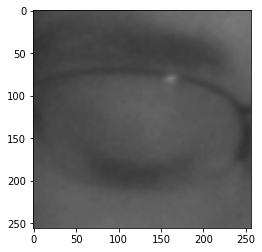

In [41]:
#Label 1 , 0 => Open eye & Label 0 , 1 => Closed eye
for image, label in val_ds.take(1):
  print("Label: ", label.numpy()[0])
  plt.imshow(image.numpy()[0].astype("uint8"))

**Lenght of Training Data and Validation Data**

In [42]:
img_count = len(glob("../input/mrl-dataset/train" +'/*/*'))
val_size = int(img_count * 0.2)
print(img_count-val_size,val_size)

3200 800


**Creating CallBacks to choose the choose the epoch's weight that gives the best score**

In [43]:
cb = [tf.keras.callbacks.ModelCheckpoint("./first_model.h5",monitor='val_accuracy',save_best_only=True,mode='max')]

**Building CNN Architecture**

In [44]:
def build():
  model = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip(mode="horizontal"),
  tf.keras.layers.RandomRotation(0.2, fill_mode='reflect',interpolation='bilinear'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
 ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])
  return model  

**Calling CNN Architecture Function**

In [45]:
model = build()

**Training our own scratch-built CNN**

In [46]:
deep_model = model.fit(train_ds,epochs=10,steps_per_epoch=math.ceil(3200/32),validation_data=val_ds,validation_steps = math.ceil(800/32),callbacks=cb)


Epoch 1/10
100/100 [==============================] - 8s 67ms/step - loss: 0.3415 - accuracy: 0.8269 - val_loss: 0.0740 - val_accuracy: 0.9787
Epoch 2/10
100/100 [==============================] - 6s 65ms/step - loss: 0.1069 - accuracy: 0.9594 - val_loss: 0.0857 - val_accuracy: 0.9812
Epoch 3/10
100/100 [==============================] - 6s 61ms/step - loss: 0.1002 - accuracy: 0.9663 - val_loss: 0.0927 - val_accuracy: 0.9613
Epoch 4/10
100/100 [==============================] - 5s 54ms/step - loss: 0.0776 - accuracy: 0.9744 - val_loss: 0.0916 - val_accuracy: 0.9712
Epoch 5/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0790 - accuracy: 0.9744 - val_loss: 0.1422 - val_accuracy: 0.9613
Epoch 6/10
100/100 [==============================] - 6s 61ms/step - loss: 0.0869 - accuracy: 0.9703 - val_loss: 0.0716 - val_accuracy: 0.9862
Epoch 7/10
100/100 [==============================] - 5s 52ms/step - loss: 0.0590 - accuracy: 0.9803 - val_loss: 0.0613 - val_accuracy: 0.9837

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (32, 256, 256, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (32, 256, 256, 3)         0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (32, 256, 256, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 125, 125, 32)       

**Visualsing Our Model's Performance**

<AxesSubplot:>

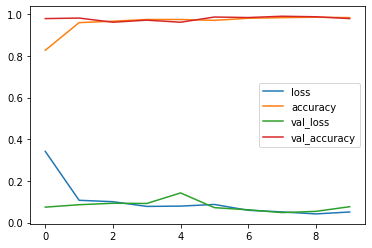

In [48]:
pd.DataFrame(deep_model.history).plot()

**Importing the best model to Test Our Model**

In [49]:
loaded_model = tf.keras.models.load_model("./first_model.h5")

**Evaluating Our Imported Model**

In [50]:
loaded_model.evaluate(val_ds,steps = math.ceil(800/32))

25/25 [==============================] - 1s 40ms/step - loss: 0.0482 - accuracy: 0.9900


[0.04824710264801979, 0.9900000095367432]

In [51]:
model.evaluate(test_ds,steps = math.ceil(400/32))

13/13 [==============================] - 1s 42ms/step - loss: 0.0626 - accuracy: 0.9808


[0.06258693337440491, 0.9807692170143127]

**Summary of our built CNN**

In [52]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (32, 256, 256, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (32, 256, 256, 3)         0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (32, 256, 256, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 125, 125, 32)       